# CSCI-UA 0473 - Introduction to Machine Learning
## Homework 4
### Assignment 4 - Adaptive RBFN and Stochastic Gradient Descent (25 Points)

The task for this homework is again that of handwritten digit recognition on the MNIST dataset.  **For this time, you will train on the full dataset (that is, 60000 training images plus 10000 test images), rather than a small subset.**

Your first goal is to implement an adaptive radial basis function network, and train it with stochastic gradient descent (SGD), while going over a few questions.

<div class="alert alert-danger">
**Please do not miss any text with red background; they are either questions you need to answer, or directions to implement some functionality.**
</div>

<div class="alert alert-warning">
**Please start this homework early.**  Stochastic gradient descent will take a particularly long time to train.
</div>

<div class="alert alert-warning">
**Please submit a fully-run notebook; not doing so would incur at least 10% penalty problem-wise.**
</div>

In [1]:
import autograd.numpy as np
import autograd.scipy as ascipy
import autograd.misc.flatten
from autograd import value_and_grad
import scipy.optimize
import pickle

import matplotlib.pyplot as plot
%matplotlib inline

## 1. Data

In [2]:
npz = np.load('mnist.npz')
# Labels
train_labels = npz['train_labels']
test_labels = npz['test_labels']
# Data.  We linearly scale the integers into something between 0 and 1.
train_data = npz['train_data'] / 255.
test_data = npz['test_data'] / 255.

The shapes and types for each numpy array is:

* `train_data`: 60000x28x28 float64 array
* `train_labels`: 60000 int64 array
* `test_data`: 10000x28x28 float64 array
* `test_labels`: 10000 int64 array

The digit for i-th training data (`train_data[i]`) is `train_labels[i]`.  The same holds for test data.

Text(0.5,1.05,'Digit 5')

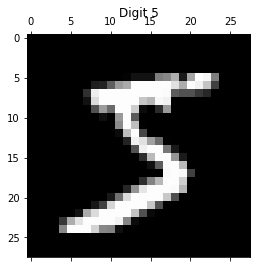

In [3]:
plot.matshow(train_data[0], vmin=0, vmax=1, cmap='gray')
# See help(str.format) or https://docs.python.org/3.1/library/string.html#formatspec for usage of the Pythonic formatter
# If you are comfortable with C you can also write things like sprintf(): 'Digit %d' % (train_labels[0])
plot.title('Digit {}'.format(train_labels[0]))

## 2. Model Definition

The first thing we need is model definition.  Recall that the Gaussian Radial Basis Function we have learned in the class transforms an arbitrary input vector $\mathbf{x} \in \mathbb{R}^d$ into another vector $\phi(\mathbf{x}) \in \mathbb{R}^k$ based on a set of bases $\mathbf{r}_k$:

$$
\phi(\mathbf{x})_k = \exp\left(\lVert \mathbf{x} - \mathbf{r}_k \rVert^2\right) = \exp \left( - \sum_{i=1}^d (x_i - r_{ki})^2\right)
$$

An alternative would be taking an average of the squares instead of summing them up:

$$
\phi(\mathbf{x})_k = \exp\left(\lVert \mathbf{x} - \mathbf{r}_k \rVert^2\right) = \exp \left( - \dfrac{1}{d} \sum_{i=1}^d (x_i - r_{ki})^2\right)
$$

<div class="alert alert-danger">
(5 points) Between the two options, which one do you think that would work better?  Justify your answer and replace the `XXX` in the `adaptive_rbfn_logits` function with your choice.  **Note: "by experiment" is not a sufficient justification for *this* problem.**
</div>

**Answer**: The use of the average of the squares works better as it prevents an outlier basis such as as a very slanted or "unorthodox" digit from skewing the results for $\phi(\textbf{x})_{k}$. We can measure how on average an input is close to a basis digit compared to how close in total an input is close to a basis digit which may be susceptible to skewing because of outlier entries in either the input vector or the basis vectors. Instead, the average will better capture relationships between the input vector and the basis vectors meaning it will work better. This observation is backed up empirically as the trained models below perform better with the average.

In [4]:
def adaptive_rbfn_logits(x, params):
    '''
    x: numpy array of training data, with shape (n_samples, 28, 28)
    params: a dictionary with "bases", "w" and "b" as keys.
    '''
    bases = params['bases']
    w = params['w']
    b = params['b']
    x = x.reshape((x.shape[0], -1))
    
    #### BEGINNING OF IMPLEMENTATION OF REPLACEMENT
    phi = np.exp(-((x[:, None, :] - bases[None, :, :]) ** 2).mean(axis=-1)) # (n_samples, n_bases)
    #### END OF IMPLEMENTATION OF REPLACEMENT
    
    #### BEGINNING OF PREVIOUS CODE FOR REFERENCE PURPOSES
    ## phi = np.exp(-((x[:, None, :] - bases[None, :, :]) ** 2).XXX(axis=-1)) # (n_samples, n_bases)
    #### END OF PREVIOUS CODE FOR REFERENCE PURPOSES
    
    logits = np.dot(phi, w) + b
    
    return logits

The function above applies a linear transformation on $\phi(\mathbf{x})$ to get the *logits* for each class.  The logits can be considered as "scores"; the higher the logit, the more likely the class.  In fact, the probability of a certain class can be directly computed by applying a *softmax* on the logits.

Recall that the multiclass logistic regression minimizes the negative log-likelihood (sometimes also called *cross entropy*) of the entire dataset:

$$
J(M, D_\text{tra}) = -\dfrac{1}{N} \sum_{(\mathbf{x}, y^*) \in D_\text{tra}}
\log \dfrac{\exp \mathbf{w}^T_{y^*} \tilde{\mathbf{x}}}{\sum_y \exp \mathbf{w}^T_y \tilde{\mathbf{x}}}
$$

<div class="alert alert-danger">
(5 points) The following function implements the cost function in a naive, numerically unstable way.  Please rewrite the indicated block **in at most 2 lines** so that it becomes numerically stable.  You will only get 2 points if your replacement is correct and more than 2 lines.
</div>

<div class="alert alert-info">
**Hint:** Recall Problem 2 in Homework 3, then look at `autograd.scipy.misc`, then see how we select elements efficiently (which is usually called [fancy](https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays) [indexing](https://docs.scipy.org/doc/numpy/user/basics.indexing.html#indexing-multi-dimensional-arrays)). <br/>

Other autodifferentiation frameworks also have their numerically stable log-softmax functions.
</div>

In [5]:
def adaptive_rbfn_cost(param_buf, x, y, unpack):
    '''
    The cost function for ARBFN.
    x: numpy array of training data, with shape (n_samples, 28, 28)
    y: numpy array of training labels, with shape (n_samples,).  All elements are integers.
    param_buf: the *flattened* numpy array containing all the parameters.
    unpack: a function that recovers the flattened parameters into the original list/dict.
    
    param_buf and unpack are quite a nuisance as they are introduced by autograd.
    A more detailed explanation comes with the "autograd.misc.flatten" function below.
    '''
    params = unpack(param_buf)
    logits = adaptive_rbfn_logits(x, params)
    
    #### BEGINNING OF IMPLEMENTATION OF REPLACEMENT
    log_probs = logits.ravel()[[i*logits.shape[1]+j for i, j in enumerate(y)]] - autograd.scipy.misc.logsumexp(logits, axis=1)
    
    ## -- this softmax is used to be with its corresponding cost function that can be
    ## -- seen below, I kept this here for reference purposes
    ## (1) softmax = logits - autograd.scipy.misc.logsumexp(logits, axis=1, keepdims=True)
    ## -- the cost below is second take at indexing, I found an even more optimized way to
    ## -- make this computation above (omitting some uneccessary subtractions)
    ## (1) cost = -(softmax.ravel()[[i*softmax.shape[1]+j for i, j in enumerate(y)]].mean())
    
    ## -- the cost below is first take at indexing, this proved to be considerably slow
    ## -- so it was omitted from the implementation and optimized above, it can be used
    ## -- with the softmax given in (1)
    ## (2) cost = -(softmax[np.arange(x.shape[0]), y].mean())
    
    cost = -log_probs.mean()
    #### END OF IMPLEMENTATION OF REPLACEMENT
    
    #### BEGINNING OF CODE TO BE REPLACED
    ## exp_logits = np.exp(logits)
    ## softmax = exp_logits / exp_logits.sum(axis=1, keepdims=True)
    ## log_probs = np.log(softmax[np.arange(x.shape[0]), y])
    ## cost = -log_probs.mean()
    #### END OF CODE TO BE REPLACED
    
    return cost

In [6]:
# This statement returns a function that has the same signature as adaptive_rbfn_cost(),
# but returns both the cost and the gradient.
adaptive_rbfn_cost_and_grad = value_and_grad(adaptive_rbfn_cost)

In [7]:
def train_full_batch(cost_and_grad, initial_params, train_data, train_labels, use_scipy=True, learning_rate=1, max_iter=30000):
    # NOTE: We should have early stopping here, but it is left for you to implement in the next problem (not here).
    # Autograd.misc.flatten() is a tricky function that allows us to compute the gradients to all parameters
    # with a single grad() call.
    # It takes in a list or dictionary, and returns two objects:
    # (1) a flattened, i.e. 1D, numpy array which contains all the parameters, and
    # (2) an unflatten function, which will recover the original list/dictionary structure from the flattened array.
    # Collapsing all the parameters into a single array would also allow us to use scipy's optimize function which
    # only takes one input variable.
    param_buf, unpack = autograd.misc.flatten(initial_params)

    if not use_scipy:
        for i in range(max_iter):
            loss, dparam_buf = cost_and_grad(param_buf, train_data, train_labels, unpack)
            param_buf -= learning_rate * dparam_buf
            if i % 100 == 0:
                print(i, loss)
    else:
        model = scipy.optimize.minimize(cost_and_grad, param_buf, (train_data, train_labels, unpack), jac=True, method='CG')
        print(model)
        param_buf = model.x
    
    return unpack(param_buf)

Now that we have defined a function for training an adaptive RBFN, let's see how a small model works on a small dataset (100 training samples, 10 test samples).

In [8]:
train_size = 100
test_size = 10
n_bases = 10
n_features = np.prod(train_data.shape[1:])

params = {}
params['bases'] = np.random.rand(n_bases, n_features)
params['w'] = np.random.randn(n_bases, 10) * 0.1
params['b'] = np.zeros(10)

In [9]:
%%time
new_params = train_full_batch(adaptive_rbfn_cost_and_grad, params, train_data[:train_size], train_labels[:train_size], False)

0 2.331095497814928
100 2.2623888489187562
200 2.261649766087085
300 2.2608647401008137
400 2.2600032503226957
500 2.2590298240994784
600 2.257901701492925
700 2.256565980954817
800 2.254956067730879
900 2.252987232605562
1000 2.250551092399784
1100 2.2475088701838404
1200 2.243683425524489
1300 2.238850333321621
1400 2.232728838017366
1500 2.2249744509425953
1600 2.215176410346268
1700 2.202865158928378
1800 2.187536953154281
1900 2.168703342475391
2000 2.1459698635612914
2100 2.119137403570674
2200 2.0883002015621357
2300 2.0538941931771566
2400 2.0166488870051613
2500 1.9774346199258042
2600 1.937060816979696
2700 1.8961158423080386
2800 1.8549083984756667
2900 1.8135052889678613
3000 1.7718192076942372
3100 1.7297013883153192
3200 1.6870154020154045
3300 1.6436867404810545
3400 1.5997309498031496
3500 1.5552641336495268
3600 1.5104983829477883
3700 1.4657240651309371
3800 1.4212817915685059
3900 1.3775286390101025
4000 1.3348044947336473
4100 1.2934041612719889
4200 1.2535589911704

In [10]:
y_hat = adaptive_rbfn_logits(test_data[:test_size], new_params).argmax(axis=1)
print(np.equal(y_hat, test_labels[:test_size]).sum(), '/', test_size)

8 / 10


When the gradient is computed from the entire training set, we usually call it *(full) batch gradient descent*.  However, batch gradient descent is time- and memory-consuming, in the sense that it has to go through all the training examples and average all the gradients for a *single* step, and it quickly becomes impractical if the dataset or the model becomes large.

The solution is *not* to see all the examples for a single gradient step.  Instead, for each step, we compute and average the gradients for only a small subset (commonly called a *minibatch*) of examples.  This is called *minibatch gradient descent*, or *stochastic gradient descent* (SGD), though the latter refer to the special case where the minibatch only contains a single example in some literatures.

The intuition behind SGD is that the minibatch gradient is a noisy but unbiased estimate of the true gradient.  This of course has pros and cons.

The main downside is that, due to the inherent noise of minibatch gradient, SGD no longer guarantees to converge to a local minimum, and sometimes it will fluctuates or even overshoot itself.  You will have to use a significantly smaller, and sometimes decaying, learning rate.  Very often, you would see a curve of training loss like [this](http://cs231n.github.io/neural-networks-3/#loss):

![](http://cs231n.github.io/assets/nn3/loss.jpeg)

The obvious upside is that estimating the gradient using minibatch is much more efficient than computing the true gradient across all training examples.  Or, after we iterate over the entire training set, we had already performed a lot of gradient steps, which is not necessarily a bad thing.  In fact, the size of a minibatch itself can be considered as a hyperparameter to fiddle with ~~although in practice few people do that~~.

In practice, SGD often works good enough, especially for large models (such as neural networks) on large datasets.

See [Leon Bottou's SGD Tricks](https://cilvr.cs.nyu.edu/diglib/lsml/bottou-sgd-tricks-2012.pdf) if you are interested in the details of SGD.

<div class="alert alert-danger">
(15 points) Implement SGD, and train your ARBFN model with 20 bases (or any number you like) on the whole dataset, with the size of minibatch being 10.  <br/>
Plot the training loss and validation accuracy, and report the test accuracy.  **Your implementation should have a test accuracy above 80% to be considered correct.** <br/>
Do the same for minibatch size 100 and answer this question in the cell below: *What do you observe from the learning curve and training time of different minibatch sizes?*  <br/>

You are free to define your own `train_sgd` function.  **Please do not use `autograd.misc.optimizers` package.**
</div>

<div class="alert alert-info">
**Hint:** To save your time figuring out the complete workflow of SGD, here is how we usually do it.
<ol>
    <li> Split the training set into a validation set and another smaller training set. </li>
    <li> Shuffle the (rest of the) training set.  Of course, you can shuffle the indices rather than the actual items. </li>
    <li> Divide the training set into equally-sized minibatches.  The last batch may not have the same size as the others, and it's up to you how to deal with it (usually it doesn't matter too much). </li>
    <li> Iterate over each minibatch, compute the gradient, and update the parameters. </li>
    <li> After going through all the minibatches (we call that *an epoch*), evaluate the model on validation set, and decide whether to early stop.  Since SGD will fluctuate a lot, you may want to leave it run for a little while longer even if the validation error does not seem to decrease.  </li>
    <li> Repeat 2-5 until done. </li>
</ol>

Optionally, you can also decay the learning rate after each minibatch or each epoch.
</div>

<div class="alert alert-warning">
**Warning:** This assignment would take potentially hours to train a model to "good performance" on an average laptop.  In practice, it is very common for neural networks to take hours, days or even weeks to train, even if powered by GPUs which are good at matrix multiplication and elementwise computation.
</div>

**Answer:** For my run when the minibatch size is increased from $10$ to $100$ then training time increases. This implies that increasing batch sizes in general should increase the training time. Conversely, increasing the batch size from $10$ to $100$ does not change the validation accuracy by a lot but has led to an increase of the testing accuracy from 0.9042 to 0.9177. In both cases the learning curves look the same for both minibatch sizes but the validation accuracy curve is much smoother when the minibatch size is $100$. Minibatch size $10$ takes 134 epochs until early stopping while minibatch size $100$ takes 245 epochs until early stopping.

In [11]:
# YOUR CODE HERE

# import shuffle for shuffling multiple datasets
from sklearn.utils import shuffle

# define training set size and validation set size
# we use 50,000 data points for training
train_size = 50000
# we use 10,000 data points for validation
val_size = 10000

# partition the sets for use
X_train, X_val = train_data[:train_size], train_data[-val_size:]
y_train, y_val = train_labels[:train_size], train_labels[-val_size:]

# the number of bases is 20 (as specified above)
n_bases = 20
n_features = np.prod(X_train.shape[1:])

# create params (parameters)
params = {}
params['bases'] = np.random.rand(n_bases, n_features)
params['w'] = np.random.randn(n_bases, 10) * 0.1
params['b'] = np.zeros(10)

# get both cost and gradient of adaptive_rbfn_cost
adaptive_rbfn_cost_and_grad = value_and_grad(adaptive_rbfn_cost)

# train_sgd function, accepts as input:
#   cost_and_grad    -- autograd computed cost and grad function
#   initial_params   -- the initial parameters, i.e. the bases, w and b
#   X_train          -- the data for the training set
#   y_train          -- the labels for the training set
#   X_val            -- the data for the validation set
#   y_val            -- the labels for the validation set
#   size_minibatches -- the size of minibatches to be used, default: 10
#   learning_rate    -- the learning rate to update the weight matrix, default: 1
#   max_iter         -- the maximum number of iterations to consider, default : 2000
#
def train_sgd(cost_and_grad, initial_params, X_train, y_train, X_val, y_val, size_minibatches=10, learning_rate=1, max_iter=2000):
    
    param_buf, unpack = autograd.misc.flatten(initial_params)
    
    # history arrays to be used to plot values
    training_loss_history = []
    valid_accuracy_history = []
    num_epochs = []
    
    # previous validation accruacy value to be used for early stopping
    prev_valid_accuracy = 0
    # patience number for early stopping, tracks number of iterations the validation accuracy stayed the same for
    patience = 0
    
    # the number of minibatches to be used
    num_minibatches = int(X_train.shape[0] / size_minibatches)
    
    # we go over max_iter number of epochs
    for i in range(max_iter):
        
        # shuffle the sets
        X_train, y_train = shuffle(X_train, y_train)
        # split the sets into minibatches
        X_train_split, y_train_split = np.array_split(X_train, num_minibatches), np.array_split(y_train, num_minibatches)
        
        # value to store estimate of the training loss for current epoch
        curr_training_loss = 0
        
        # iterate over each minibatch and update parameters loss and param_buf
        for minibatch in range(num_minibatches):
            loss, dparam_buf = cost_and_grad(param_buf, X_train_split[minibatch], y_train_split[minibatch], unpack)
            curr_training_loss += loss
            param_buf -= learning_rate * dparam_buf
        
        # estimate overall training_loss by taking average over the batches
        curr_training_loss /= num_minibatches
        
        # use current epoch trained model on validation set
        y_hat = adaptive_rbfn_logits(X_val, unpack(param_buf)).argmax(axis=1)
        
        # if first iteration simply update prev_valid_accuracy, else do early stopping
        if i == 0:
            prev_valid_accuracy = np.equal(y_hat, y_val).sum() / val_size
        else:
            # compute new validation accuracy
            new_valid_accuracy = np.equal(y_hat, y_val).sum() / val_size
            # if better than previous then update previous and reset patience
            if new_valid_accuracy > prev_valid_accuracy:
                prev_valid_accuracy = new_valid_accuracy
                patience = 0
            else:
                # if it has been too many iterations (i.e. 20) exit loop, else update patience
                if (patience > 20):
                    print("Epoch #", i, "-- Training loss:", curr_training_loss, "-- Validation accuracy:", prev_valid_accuracy)
                    break
                else:
                    patience += 1
                    
        # debugging statement below, uncomment to observe the results of each epoch           
        # print("Epoch #", i, "-- Training loss:", curr_training_loss, "-- Validation accuracy:", prev_valid_accuracy)
        
        # update history arrays
        training_loss_history.append(curr_training_loss)
        valid_accuracy_history.append(prev_valid_accuracy)
        num_epochs.append(i)
        
    # return the results as a tuple of the learned model and the history arrays        
    return (unpack(param_buf), training_loss_history, valid_accuracy_history, num_epochs)

In [12]:
%%time
results_1 = train_sgd(adaptive_rbfn_cost_and_grad, params, X_train, y_train, X_val, y_val)

Epoch # 134 -- Training loss: 0.29656937084429325 -- Validation accuracy: 0.9272
CPU times: user 1h 49min 12s, sys: 2min 31s, total: 1h 51min 44s
Wall time: 1h 51min 44s


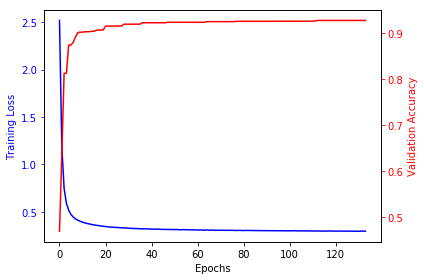

In [13]:
# plot the results from results_1 (minibatch size = 10)
fig, ax1 = plot.subplots()
ax1.plot(results_1[1], 'b-', label='Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(results_1[2], 'r-', label='Validation Accuracy')
ax2.set_ylabel('Validation Accuracy', color='r')
ax2.tick_params('y', colors='r')
fig.tight_layout()

In [14]:
# report the test accuracy for results_1 (minibatch size = 10)
param_buf, unpack = autograd.misc.flatten(results_1[0])
y_hat = adaptive_rbfn_logits(test_data, unpack(param_buf)).argmax(axis=1)
test_accuracy = np.equal(y_hat, test_labels).sum() / (test_labels.shape[0])
print("The test accuracy when minibatch size = 10 is:", test_accuracy)

The test accuracy when minibatch size = 10 is: 0.9042


In [15]:
%%time
results_2 = train_sgd(adaptive_rbfn_cost_and_grad, params, X_train, y_train, X_val, y_val, 100)

Epoch # 245 -- Training loss: 0.30006747027315717 -- Validation accuracy: 0.923
CPU times: user 2h 17min 33s, sys: 15min 35s, total: 2h 33min 8s
Wall time: 4h 40min 39s


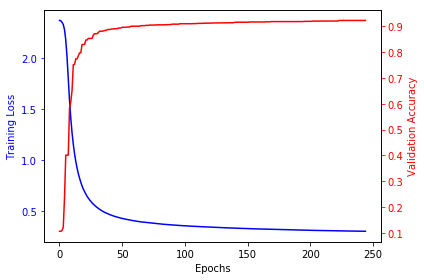

In [16]:
# plot the results from results_2 (minibatch size = 100)
fig, ax1 = plot.subplots()
ax1.plot(results_2[1], 'b-', label='Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(results_2[2], 'r-', label='Validation Accuracy')
ax2.set_ylabel('Validation Accuracy', color='r')
ax2.tick_params('y', colors='r')
fig.tight_layout()

In [17]:
# report the test accuracy for results_2 (minibatch size = 100)
param_buf, unpack = autograd.misc.flatten(results_2[0])
y_hat = adaptive_rbfn_logits(test_data, unpack(param_buf)).argmax(axis=1)
test_accuracy = np.equal(y_hat, test_labels).sum() / (test_labels.shape[0])
print("The test accuracy when minibatch size = 100 is:", test_accuracy)

The test accuracy when minibatch size = 100 is: 0.9177


For reference, here is our training loss and validation accuracy curve running for 2000 epochs.  Your training and validation curve does *not* need to look like ours; this is only supposed to give you a rough idea of how the curves would look like.

![](curve.png)

### Assignment 5: k-NN Classifier (15 points)

The second goal is to compare you ARBFN against a k-NN classifier.  For the k-NN classifier, you need to try a couple $k$'s and pick the best one in a programmatic way.

<div class="alert alert-danger">
(15 points) Build a k-NN classifier using `scikit-learn` with $k$'s from 1 to 3, train it on the first 1000 examples of MNIST dataset, and report the accuracy on the full test set. <br/>

Would you use the (exact) k-NN classifier you have built for very large dataset (with maybe millions of examples)?  Explain your answer.
</div>

In [18]:
# YOUR CODE HERE

from sklearn.neighbors import KNeighborsClassifier

# flatten the training set so that it can work with sklearn
X_train, y_train = train_data[:1000].reshape(1000, 28*28), train_labels[:1000]
# flatten the testing set so that it can work with sklearn    
X_test, y_test = test_data.reshape(test_data.shape[0], 28*28), test_labels

# optimal k variable
best_k = 1
best_score = 0

for k in range(1, 4):
    # let sklearn pick the best algorithm and use Euclidean distance as distance metric (p = 2)
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='auto', p=2)
    knn.fit(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    print("Testing accuracy for knn when k =", k, "is: ", test_score)
    if test_score > best_score:
        best_k = k
        best_score = test_score

print("The best k for knn is k =", best_k, "with testing accuracy: ", best_score)

Testing accuracy for knn when k = 1 is:  0.869
Testing accuracy for knn when k = 2 is:  0.8496
Testing accuracy for knn when k = 3 is:  0.8622
The best k for knn is k = 1 with testing accuracy:  0.869


**Answer:** We see that the best testing accuracy is obtained when $k = 1$ from our k-NN models trained on the first 1000 examples of the MNIST dataset. I would most likely not use the k-NN classifier I have built with $k = 1$ as I except the accuracy of my model to decrease as the amount of testing samples increase. This is because I firstly estimate that we will need a larger $k$ when the number of samples increases due to the increased possibility of obtaining slanted or distorted samples that may be misclassified with only one near neighbor. Secondly, if $1000$ training examples leads to $0.869$ testing accuracy for a test set with $10000$ samples, it is most likely that increasing the test set size will mean that our model will not scale well due to a possibly changing distribution of the samples of the new testing data. However, if the new very large testing set shares similar distributions and samples to our current training and testing sets, then using this model will be appropriate.